In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# batched data generating function

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# weight function

In [3]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# model

In [4]:
pr = 2
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq1024_pr'+str(pr)+'.h5'
modelstore = '/Volumes/Mac/GW/model/model-resnet3-1.ckpt'

In [5]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

6390


In [6]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent
#total
totalpix = lenf*lent
print 'total',totalpix
#idx of f=1024
idx1024 = (lenf-1)/4
print 'idx1024=',idx1024


batchSize = 10
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 7 #conv1 filter size
c1fn = 2 #conv1 filter number
c2fs = 5 #conv2 filter size
c2fn = 4 #conv2 filter number
c3fs = 3 #conv3 filter size
c3fn = 8 #conv3 filter number
dos1 = idx1024+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =32 #layer1 neuron number

lenth f = 257
lenth t = 121
total 31097
idx1024= 64


In [7]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,通道維度)
    
with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(x_image, w1) + b1
    c1_conv = tf.nn.relu(conv1)
#輸出[dos1, dos2, 2] 

with tf.name_scope('c1_pool'):
    c1_pool = maxpool2x2(c1_conv)
#輸出[dos1/2, dos2/2, 2]
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_pool,w2) +b2
    c2_conv = tf.nn.relu(conv2)
#輸出[dos1/2, dos2/2, 4]
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(c2_conv, w3) + b3
#輸出[dos1/2, dos2/2, 8]
    #datanum = conv3.shape.as_list()[0]
    #dim1 = conv3.shape.as_list()[1]
    #dim2 = conv3.shape.as_list()[2]
    increase_dim3 = conv3.shape.as_list()[3]-c1_pool.shape.as_list()[3]
    #shape = tf.constant([,dim1,dim2,increase_dim3],shape=[4])
    #zeropadding = tf.zeros(shape)
    zeropadding = tf.zeros_like(conv3)[:,:,:,0:increase_dim3]
    
    
    #shortcut connection
    c3_rl = conv3 + tf.concat([c1_pool,zeropadding], 3)
    c3_conv = tf.nn.relu(c3_rl)

    

#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c3_conv)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# evaluate

In [8]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq1024_pr'+str(peakratio)+'.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq1024_pr'+str(peakratio)+'.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    print 'acc :', sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    
def prediction_result(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [9]:
def relation(n):
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [10]:
evaluate(2,2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.313516021 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313296974 Accuracy= 1.0
period(s) = 274.745117903


In [10]:
evaluate(2,1.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.314177930 Accuracy= 0.9993333
Train Epoch: 02 Loss= 0.314425528 Accuracy= 0.999
period(s) = 257.759809971


In [10]:
evaluate(2,1.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.314229399 Accuracy= 0.999
Train Epoch: 02 Loss= 0.313352972 Accuracy= 1.0
period(s) = 258.773273945


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.338244468 Accuracy= 0.97466666
Train Epoch: 02 Loss= 0.315348804 Accuracy= 0.99833333
Train Epoch: 03 Loss= 0.317228407 Accuracy= 0.9956667
Train Epoch: 04 Loss= 0.317294568 Accuracy= 0.996
period(s) = 692.270844936


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.317127168 Accuracy= 0.996
Train Epoch: 02 Loss= 0.317669272 Accuracy= 0.9953333
Train Epoch: 03 Loss= 0.315189034 Accuracy= 0.99766666
Train Epoch: 04 Loss= 0.317229778 Accuracy= 0.996
period(s) = 697.945161819


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.318542063 Accuracy= 0.9946667
Train Epoch: 02 Loss= 0.320680827 Accuracy= 0.9913333
Train Epoch: 03 Loss= 0.314132571 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.317405939 Accuracy= 0.9956667
period(s) = 783.960751057


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.324232310 Accuracy= 0.989
Train Epoch: 02 Loss= 0.328446120 Accuracy= 0.98466665
Train Epoch: 03 Loss= 0.327699214 Accuracy= 0.98466665
Train Epoch: 04 Loss= 0.323519737 Accuracy= 0.98933333
period(s) = 730.287761927


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.320838064 Accuracy= 0.992
Train Epoch: 02 Loss= 0.321181178 Accuracy= 0.99233335
Train Epoch: 03 Loss= 0.319793582 Accuracy= 0.994
Train Epoch: 04 Loss= 0.317263961 Accuracy= 0.997
period(s) = 703.902709007


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.316783935 Accuracy= 0.997
Train Epoch: 02 Loss= 0.317056119 Accuracy= 0.99633336
Train Epoch: 03 Loss= 0.316506952 Accuracy= 0.99666667
Train Epoch: 04 Loss= 0.317714959 Accuracy= 0.9956667
period(s) = 693.213109016


In [10]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.330945760 Accuracy= 0.983
Train Epoch: 02 Loss= 0.328800738 Accuracy= 0.98433334
Train Epoch: 03 Loss= 0.326840729 Accuracy= 0.9866667
Train Epoch: 04 Loss= 0.327278376 Accuracy= 0.987
period(s) = 725.642460108


In [10]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.325450361 Accuracy= 0.98733336
Train Epoch: 02 Loss= 0.324147880 Accuracy= 0.98833334
Train Epoch: 03 Loss= 0.324037999 Accuracy= 0.98833334
Train Epoch: 04 Loss= 0.323464543 Accuracy= 0.99
period(s) = 731.075989008


In [10]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.323258132 Accuracy= 0.98933333
Train Epoch: 02 Loss= 0.323080480 Accuracy= 0.98933333
Train Epoch: 03 Loss= 0.322726041 Accuracy= 0.98966664
Train Epoch: 04 Loss= 0.322719812 Accuracy= 0.99
period(s) = 716.194238186


In [10]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.334716439 Accuracy= 0.97866666
Train Epoch: 02 Loss= 0.331770658 Accuracy= 0.9816667
Train Epoch: 03 Loss= 0.331056654 Accuracy= 0.982
Train Epoch: 04 Loss= 0.329332203 Accuracy= 0.98333335
period(s) = 684.49573493


In [10]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.328875899 Accuracy= 0.98433334
Train Epoch: 02 Loss= 0.329320103 Accuracy= 0.98366666
Train Epoch: 03 Loss= 0.329428703 Accuracy= 0.98366666
Train Epoch: 04 Loss= 0.328561217 Accuracy= 0.98433334
period(s) = 690.302572966


In [10]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.329323411 Accuracy= 0.98333335
Train Epoch: 02 Loss= 0.330503374 Accuracy= 0.982
Train Epoch: 03 Loss= 0.329053760 Accuracy= 0.98366666
Train Epoch: 04 Loss= 0.329416662 Accuracy= 0.983
period(s) = 748.868665934


In [10]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.369815588 Accuracy= 0.9406667
Train Epoch: 02 Loss= 0.365702718 Accuracy= 0.9443333
Train Epoch: 03 Loss= 0.363857001 Accuracy= 0.946
Train Epoch: 04 Loss= 0.356376380 Accuracy= 0.9536667
period(s) = 763.629023075


In [10]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.357889801 Accuracy= 0.9533333
Train Epoch: 02 Loss= 0.355432540 Accuracy= 0.95633334
Train Epoch: 03 Loss= 0.355623037 Accuracy= 0.95633334
Train Epoch: 04 Loss= 0.357020766 Accuracy= 0.955
period(s) = 719.623903036


In [10]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.359920084 Accuracy= 0.95133334
Train Epoch: 02 Loss= 0.362891912 Accuracy= 0.94733334
Train Epoch: 03 Loss= 0.360547572 Accuracy= 0.951
Train Epoch: 04 Loss= 0.361077040 Accuracy= 0.95033336
period(s) = 693.182389021


In [10]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.419100463 Accuracy= 0.8883333
Train Epoch: 02 Loss= 0.414881200 Accuracy= 0.8936667
Train Epoch: 03 Loss= 0.412902623 Accuracy= 0.896
Train Epoch: 04 Loss= 0.410978109 Accuracy= 0.896
period(s) = 733.256481171


In [10]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.413537681 Accuracy= 0.896
Train Epoch: 02 Loss= 0.413923860 Accuracy= 0.8936667
Train Epoch: 03 Loss= 0.416018486 Accuracy= 0.89133334
Train Epoch: 04 Loss= 0.415821940 Accuracy= 0.893
period(s) = 716.445924044


In [10]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
Train Epoch: 01 Loss= 0.413838893 Accuracy= 0.89666665
Train Epoch: 02 Loss= 0.416070402 Accuracy= 0.8946667
Train Epoch: 03 Loss= 0.418201506 Accuracy= 0.8923333
Train Epoch: 04 Loss= 0.419128329 Accuracy= 0.89066666
period(s) = 727.077152967


In [10]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
acc : 0.90260786
period of estimate = 36.7751820087 (s)


In [11]:
test = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5', 'r')
test_label = test['label'][...]
test.close()
cc=confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5'),
               test_label)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 36.2578709126 (s)
confusionmatrix =
[[3547  180]
 [ 425 2060]]


In [12]:
false_alarm_rate(cc)
sensitivity(cc)

false alarm rate = 0.04829621679635095
sensitivity = 0.8289738430583501


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 29.7791030407 (s)
confusionmatrix =
[[ 536   16]
 [ 874 4096]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 29.4480140209 (s)
confusionmatrix =
[[ 520   32]
 [ 869 4101]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.2278888226 (s)
confusionmatrix =
[[ 527   25]
 [ 880 4090]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 29.861768961 (s)
confusionmatrix =
[[ 526   26]
 [ 839 4131]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 29.4365561008 (s)
confusionmatrix =
[[ 524   28]
 [ 835 4135]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 29.5375580788 (s)
confusionmatrix =
[[

period of prediction = 34.9545660019 (s)
confusionmatrix =
[[ 531   21]
 [ 886 4084]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 32.2659168243 (s)
confusionmatrix =
[[ 526   26]
 [ 869 4101]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 33.8553049564 (s)
confusionmatrix =
[[ 518   34]
 [ 842 4128]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 32.4970228672 (s)
confusionmatrix =
[[ 529   23]
 [ 875 4095]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.9258730412 (s)
confusionmatrix =
[[ 521   31]
 [ 849 4121]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.2244079113 (s)
confusionmatrix =
[[ 530   22]
 [ 872 4098]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/m

period of prediction = 30.2024960518 (s)
confusionmatrix =
[[ 533   19]
 [ 814 4156]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.540004015 (s)
confusionmatrix =
[[ 520   32]
 [ 837 4133]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.0627770424 (s)
confusionmatrix =
[[ 521   31]
 [ 890 4080]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet3-1.ckpt
period of prediction = 30.9728419781 (s)
confusionmatrix =
[[ 527   25]
 [ 852 4118]]
acc = 0.8405849329952916
sensitivity = 0.8280945674044266
false alarm rate = 0.04695652173913043


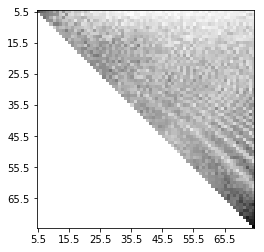

In [13]:
relation(100)